**Część pierwsza: instalacja oraz aktualizacja potrzebnych bibliotek.**

In [2]:
#installing imorant kaggle and other important code fragments 
!pip install kaggle
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade
!pip install nltk

**Część druga: import bibliotek i rozszerzeń**


Scikit-learn - uczenie maszynowe oraz analiza danych 

Keras - procesowanie i analiza danych, zamiana tekstu na tokeny

Matplot - rysowanie wykresów (wykorzystane później w celu narysowania zysków/strat efektywności w algorytmie na przestrzeni pokoleń)

Nltk - nardzędzia przydatne w tworzeniu modeli językowych

Gensim - biblioteka open-source dla modeli tematów
(model tematów - model uczenia nienadzorowanego, w którym wyciąga się najważniejsze informacje z tekstu poprzez groupwanie słów i znaczeń)


In [3]:
# DataFrame
import pandas as pd

# Matplot
#rysowanie wykresów (wykorzystane później w celu narysowania zysków/strat efektywności w algorytmie na przestrzeni pokoleń)
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
# preprocesing danych, ocena modeli, abstrahowanie (feature extraction) - wyciąganie najważniejszych informacji 
from sklearn.model_selection import train_test_split #Podział danych na testowe i uczące
from sklearn.preprocessing import LabelEncoder #Będzie umożliwiał otagowanie tekstów ich ich klasą 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score #Do póżniejszego oceniania modelu i pokazanie jego wyników na tabeli 
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

#Keras
#Przede wszystkim tworzenie i uczenie modeli, także procesowanie i analiza danych, zamiana tekstu na tokeny. 
#Jest to API uczenia maszynowego między człowiekiem a pythonem. 
from tensorflow.keras.preprocessing.text import Tokenizer #"Tokenizer" umożlwiia zamianę słów i wyrazów na tokeny, czyli znacznie / viby, lub idee w sensie platonicznym.
#Przykładem tokenu jest pies, które może być wyrażone za pomocą słowa "dog", "hound", "doggy", "puppy" itp. 
#Tokenem może być słowo, podsłowo (podzbiór słowa), a nawet pojedynczy znak.
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM #narzędzia tworzenia modelu, w szczególności warst neuronów
#Activation - algorytm determinujący, dla jakich danych neuron się aktywuje
#Dense - warstwa połączeń wszyscy do wszystkich
#Dropout - przeciwdziała przetrenowaniu
#Embedding - zamiana liczb (intigers) na wektory. W szczególności użytecne w modelach językowych (opartych na wektorach opisujących zależności między słowami)
#Flatten - redukcja wymiarowości bez zmiejszania próby (np. z 3 x 3 na 1 x 9), szczególnie przydatne dla warstwy "dense" (wszystko do wszystkich)
#Max pooling - sygnały stike back - zmiejszanie matrycy przez "przejechanie" po niej filterm. [1,5,10,6; 3,11,9,6 ; 4,3,1,1, ; 16,9,2,2] -> [11,10 ; 16,2]
#Long Short-Term Memory (długotrwała pamięć skrótkotrwała) - jeden z trików na problem zanikającego gradientu
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk 
import nltk
#NLTK oznacza Natural Language Toolkit
from nltk.corpus import stopwords 
#stopwords - słowa generalnie bez informacji, jak np. "the", "an", "a" w języku angielskim 
from  nltk.stem import SnowballStemmer
#Stemming to redukcja słowa do jego słowa bazowego lub rdzenia w taki sposób, że słowa podobnego rodzaju znajdują się pod wspólnym rdzeniem. 
#Na przykład – słowa care, cared i caring znajdują się pod tym samym rdzeniem „care”

# Word2vec
#Self-explanatory
import gensim
# biblioteka open-source dla modeli tematów
#model tematów - model uczenia nienadzorowanego, w którym wyciąga się najważniejsze informacje z tekstu poprzez groupwanie słów i znaczeń

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
#Pobranie "Stop wordów" 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# DATASET
# Informacje jak wyglądają dane odnośnie twitów
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"] #W bazie danych mamy 7 kolumn, gdzie najważniejsze (tekst i sentyment) to pierwsza i ostatnia
#target - czy twitt jest pozytywny (4), neutralny (2) lub negatywny (0). "Flag" to najprawdopodobniej metadata. 
#Każdy twitt też ma id "ids", datę zapostowania  "date", autora "user" oraz sam tekst - "text"
DATASET_ENCODING = "ISO-8859-1" #często używane w zbiorze dancych w których występują znaki specjalne 
TRAIN_SIZE = 0.8 #jaki % danych będzie użyte do czenia, a jaki procent do testowania

# TEXT CLEANING
# usunięcie przedrostków https albo http z tekstu
TEXT_CLEANING_RE = r"@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
# osadzenie słów
W2V_SIZE = 300 #Ile wymiarów będzie posiadał słowo-wektor
W2V_WINDOW = 7 #Na ile wyrazów obok będzie patrzył model tworząc powiązania
W2V_EPOCH = 32 #Liczba pokoleń
W2V_MIN_COUNT = 10 #Limit - jeżeli wyraz pojawia się mniej niż minimalną liczbę razy (tutaj 10), będzie ignorowany  

# KERAS
# wprowadzenie parametrów uczenia maszynowego
SEQUENCE_LENGTH = 300 #maksymalna długość tekstu wprowadzone 
EPOCHS = 8 #Liczba pokoleń
BATCH_SIZE = 1024 #Liczba tekstów analizowanych w jednym pokoleniu - im więcej tym lepszy proces uczenia, ale zajmuje więcej czasu

# SENTIMENT
#Przypisanie rezultatów do skali liczbowej, przypisanie nazw do rezultatów 
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)
#Innymi słowy below 0.4 : Negative, 0.4.-0.7 : Neutral, above 0.7 (Positive) 

# EXPORT
#Jak będzie nazwany model po eksporcie 
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

**Dataset details**

target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

ids: The id of the tweet (2087)

date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (robotickilldozr)

text: the text of the tweet (Lyx is cool)

In [6]:
dataset_path = r"C:\Users\aleks\Downloads\training.1600000.processed.noemoticon.csv"
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: C:\Users\aleks\Downloads\training.1600000.processed.noemoticon.csv


In [7]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [8]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**Klasa z numeru jest zamieniana na tekst (intiger into string)**

0 -> NEGATIVE

2 -> NEUTRAL

4 -> POSITIVE

In [9]:
#Klasa z numeru jest zamieniana na tekst (intiger into string)

decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"} #przypisanie tekstu do tagu klasy
def decode_sentiment(label): #definicja funkcji, która odczytuje metki / taki / labelki (label) i przyłączy im ich tekstowy odpowiednich zgodnie z słownikiem "decode_map"
    return decode_map[int(label)]

In [10]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x)) # Konwertuje numeryczne etykiety sentymentu w kolumnie 'target' DataFrame na ich tekstowe odpowiedniki.

CPU times: total: 219 ms
Wall time: 226 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

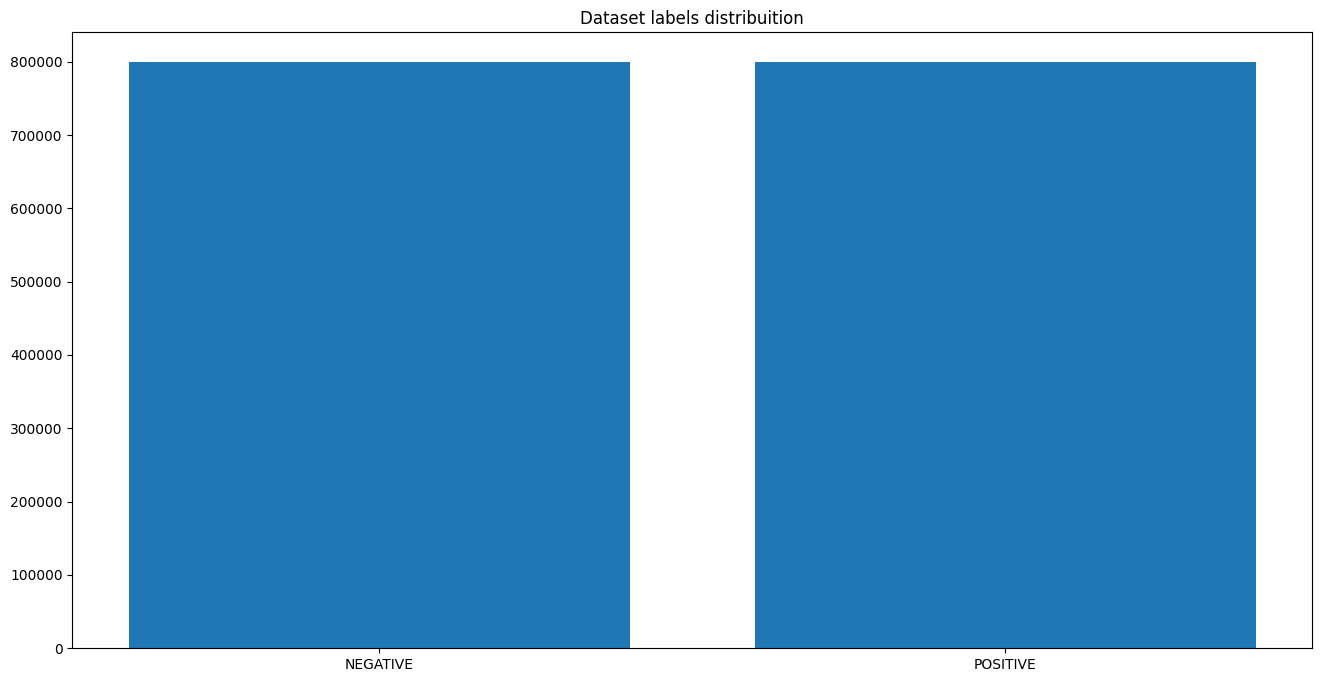

In [11]:
#Tabela preentująca podział klas w danych twittów
target_cnt = Counter(df.target)

#konfiguracja wykresu 
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition") #tytuł wykresu

**Tabela preentująca podział klas w danych twittów**

Jak widać twittów negatywnych jest około tyle samo ile twittów pozytywnych

In [12]:
#Pre-Process dataset - pobranie danych służących czyszczeniu danych 

stop_words = stopwords.words("english") #stop words to słowa bez własnego znaczenia, w angielskim będą to "the", "an", "a" itd.

stemmer = SnowballStemmer("english") #Stemmer, od "stem" czyli łodyga/pień, to centralne znaczenie słowa. 
#Stemmering to proces sprowadzenia słowa do jego podstawowego znaczenia, np. "runnning" zamieniamy na "run". Jest to zmiejszanie wariacji / wymiarowości słów w tekście

In [13]:
#Preprocesing - rozbicie tekstu na tokeny (słowa/wyrazy), usunięcie stopwordów (zbędnych wyrazów) 

def preprocess(text, stem=False): 
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip() #usuwanie wielkich liter [.lower()] i odstępów (ang. whitespace) na początku i końcu tekstu [.strip()]
    #usuwa fragmenty "https" oraz "http" przez usunięcie wszystkiego co pasuje do fragmentu z początku - TEXT_CLEANING_RE
    
    tokens = [] #tworzymy pustą lista na dodanie tokenów 
    
    for token in text.split(): #rozbicie tekstu na tokeny (słowa), przez rozbicia w miejscach spacji
        if token not in stop_words: #stop wordy nie będą miały własnego znaczenia, będą miały znikomą korzyść dla analizy i są ignorowane 

            #możliwe stemowanie - zamiana tokenu na jego formę podstawoą 
            if stem:
                tokens.append(stemmer.stem(token)) #stem = True - token jest dodany do listy jego wcześniejszym uproszczeniu 
            else:
                tokens.append(token) #stem = False - po prostu dodajemu token do listy 
                
    return " ".join(tokens) #zwracamy tekst (w formie tokenów, pozbawiony wyrazów zbędnych) oddzielonych spacjami 

In [14]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 29.7 s
Wall time: 30.6 s


In [15]:
#Podział na dane testowe (test) oraz uczące (train)
#TRAIN_SIZE = 0.8, danych uczących będzie 80%, danych testowych 20%

df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
#random state ułatwia analizę kodu przez eliminację losowości, jednocześnie umożliwiając jej póżniejsze dodanie i eksperymenty przez zmienianie random state
print("TRAIN size:", len(df_train)) #wyświetlanie wielkości zbioru uczącego
print("TEST size:", len(df_test)) #wyświetlanie wielkości zbioru testowego

TRAIN size: 1280000
TEST size: 320000


Słowa -> Wektory

In [16]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: total: 2 s
Wall time: 2.06 s


In [17]:
#Zamiane słów na wektory, w oparciu o warunki ustalone na początku kodu
#Dla przypomnienia 
#W2V_SIZE = 300 - tyle wymiarów ma wektor
#W2V_WINDOW = 7 - tyle wyrazów z sąsiedztwa będziemy analizować
#W2V_MIN_COUNT = 10 - ile minimalnie musi wyraz wystąpić, żeby był analizowany 

w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2024-12-17 12:36:00,836 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2024-12-17T12:36:00.836629', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'created'}


In [18]:
#Budowanie słowanika 
w2v_model.build_vocab(documents)

2024-12-17 12:36:00,841 : INFO : collecting all words and their counts
2024-12-17 12:36:00,843 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-12-17 12:36:00,850 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2024-12-17 12:36:00,857 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2024-12-17 12:36:00,864 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2024-12-17 12:36:00,873 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2024-12-17 12:36:00,880 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2024-12-17 12:36:00,888 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2024-12-17 12:36:00,897 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2024-12-17 12:36:00,904 : INFO : PROGRESS: at s

In [19]:
words = list(w2v_model.wv.index_to_key)  # List of vocabulary words
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [20]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2024-12-17 12:36:03,087 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2024-12-17T12:36:03.087956', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'train'}
2024-12-17 12:36:04,106 : INFO : EPOCH 0 - PROGRESS: at 27.64% examples, 2267289 words/s, in_qsize 15, out_qsize 0
2024-12-17 12:36:05,106 : INFO : EPOCH 0 - PROGRESS: at 56.18% examples, 2308736 words/s, in_qsize 15, out_qsize 0
2024-12-17 12:36:06,107 : INFO : EPOCH 0 - PROGRESS: at 85.23% examples, 2333879 words/s, in_qsize 16, out_qsize 0
2024-12-17 12:36:06,604 : INFO : EPOCH 0: training on 9227204 raw words (8222483 effective words) took 3.5s, 2349101 effective words/s
2024-12-17 12:36:07,619 : INFO : EPOCH 1 - PROGRESS: at 27.64% examples, 2266903 words/s, in_qsize 1

(263124030, 295270528)

In [21]:
#pokaz efektów - program wyświetlna słowa najbardziej podobne do słowa "miłość" (love)
similar_words = w2v_model.wv.most_similar("love")
print(similar_words)

[('luv', 0.5765488147735596), ('loves', 0.5636578798294067), ('loved', 0.5434289574623108), ('adore', 0.50634765625), ('amazing', 0.48880043625831604), ('looove', 0.4886596202850342), ('awesome', 0.4601627588272095), ('loooove', 0.45898008346557617), ('looooove', 0.4411940574645996), ('lovee', 0.43854889273643494)]


**Tokenizacja Tekstu**

In [22]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: total: 12 s
Wall time: 12.2 s


In [23]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 17.5 s
Wall time: 17.9 s


In [24]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

**Podział danych na testowe i treningowe**

In [25]:
#Tworzenie danych treningowych oraz testowych, poprzez otagowanie tekstów. 
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [29]:
#Zapisywanie danych treningowych oraz testowych w osobnych plikach na potrzeby testów

output_dir = "Dane"
os.makedirs(output_dir, exist_ok=True)

np.savetxt(os.path.join(output_dir, 'y_train.txt'), y_train)
np.savetxt(os.path.join(output_dir, 'y_test.txt'), y_test)
np.savetxt(os.path.join(output_dir, 'x_train.txt'), x_train)
np.savetxt(os.path.join(output_dir, 'x_test.txt'), x_test)

In [ ]:
#Stan danych uczących się i treningowych
#Dane tekstu mają 300 wymiarów (x) zarówno w danych treningowych oraz testowych, tak jak wektory słów
#Dane klas mają tylko 1 wymiar (y)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

In [ ]:
y_train[:10]

Embedding layer

In [40]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [41]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], trainable=False)

In [42]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      87,125,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,125,700 (332.36 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 87,125,700 (332.36 MB)

Compile Model

In [43]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Callbacks

In [44]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Train

In [45]:
%%time

from keras.callbacks import EarlyStopping
callbacks = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)
]

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2177s 2s/step - accuracy: 0.7307 - loss: 0.5288 - val_accuracy: 0.7786 - val_loss: 0.4644
Epoch 2/8
1048/1125 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.7638 - loss: 0.4842 

KeyboardInterrupt: 

In [ ]:
if history and 'accuracy' in history.history:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    # Plot accuracy
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    # Plot loss
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
else:
    print("Training did not complete successfully. No history available.")

In [ ]:
#model.save(KERAS_MODEL)
#w2v_model.save(WORD2VEC_MODEL)
#pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
#pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)